In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Config
img_size = 224
batch_size = 32
num_classes = 5   # thumb, index, middle, ring, little


2025-09-17 12:07:55.951778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758110876.146239      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758110876.216436      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Dataset paths
train_paths = [
    "../input/socofing/SOCOFing/Altered/Altered-Easy",
    "../input/socofing/SOCOFing/Altered/Altered-Medium",
    "../input/socofing/SOCOFing/Altered/Altered-Hard"
]
test_paths = ["../input/socofing/SOCOFing/Real"]

# Function to extract finger label from filename
def extract_label(img_path, train=True):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    subject_id, etc = filename.split('__')
    if train:
        gender, lr, finger, _, _ = etc.split('_')
    else:
        gender, lr, finger, _ = etc.split('_')
    mapping = {"thumb":0, "index":1, "middle":2, "ring":3, "little":4}
    return np.array([subject_id, mapping[finger], lr, gender], dtype=object)


In [3]:
from tensorflow.keras.utils import Sequence

class FingerDataGenerator(Sequence):
    def __init__(self, img_paths, labels, batch_size=32, img_size=224, num_classes=5, shuffle=True):
        self.img_paths = img_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.img_paths))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        batch_paths = [self.img_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        
        X = np.zeros((len(batch_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_paths), self.num_classes), dtype=np.float32)
        
        for i, path in enumerate(batch_paths):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = np.stack([img]*3, axis=-1) / 255.0
            X[i] = img
            y[i] = to_categorical(batch_labels[i], num_classes=self.num_classes)
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Helper: collect image paths & labels
def get_paths_and_labels(folder_paths, train=True):
    img_paths = []
    labels = []
    for folder in folder_paths:
        for img in os.listdir(folder):
            try:
                path = os.path.join(folder, img)
                label = extract_label(path, train=train)[1]  # finger index
                img_paths.append(path)
                labels.append(label)
            except:
                pass
    return img_paths, labels


In [4]:
# Collect paths and labels
X_train_paths, y_train = get_paths_and_labels(train_paths, train=True)
X_test_paths, y_test = get_paths_and_labels(test_paths, train=False)

# Split train into train + validation
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    X_train_paths, y_train, test_size=0.2, random_state=42
)

# Generators
train_generator = FingerDataGenerator(X_train_paths, y_train, batch_size, img_size, num_classes)
val_generator = FingerDataGenerator(X_val_paths, y_val, batch_size, img_size, num_classes, shuffle=False)
test_generator = FingerDataGenerator(X_test_paths, y_test, batch_size, img_size, num_classes, shuffle=False)

print(f"Train samples: {len(X_train_paths)}")
print(f"Val samples: {len(X_val_paths)}")
print(f"Test samples: {len(X_test_paths)}")


Train samples: 39416
Val samples: 9854
Test samples: 6000


In [5]:
# Base DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_size,img_size,3)))

# 🔹 Freeze most layers, unfreeze last 30 for fine-tuning
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Small learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


I0000 00:00:1758110888.753701      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,564,869 (28.86 MB)

 Trainable params: 1,168,773 (4.46 MB)

 Non-trainable params: 6,396,096 (24.40 MB)

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1758110917.936452      60 service.cc:148] XLA service 0x7f9368004720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758110917.937231      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758110921.088089      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1232 ━━━━━━━━━━━━━━━━━━━━ 1:12 59ms/step - accuracy: 0.1875 - loss: 2.4822   

I0000 00:00:1758110935.869093      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 477s 354ms/step - accuracy: 0.3276 - loss: 1.6685 - val_accuracy: 0.5767 - val_loss: 1.0471 - learning_rate: 1.0000e-05
Epoch 2/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 100s 81ms/step - accuracy: 0.5298 - loss: 1.1401 - val_accuracy: 0.6254 - val_loss: 0.9448 - learning_rate: 1.0000e-05
Epoch 3/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 109s 88ms/step - accuracy: 0.5787 - loss: 1.0328 - val_accuracy: 0.6559 - val_loss: 0.8790 - learning_rate: 1.0000e-05
Epoch 4/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 115s 93ms/step - accuracy: 0.6171 - loss: 0.9458 - val_accuracy: 0.6805 - val_loss: 0.8255 - learning_rate: 1.0000e-05
Epoch 5/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 110s 89ms/step - accuracy: 0.6415 - loss: 0.8892 - val_accuracy: 0.7013 - val_loss: 0.7780 - learning_rate: 1.0000e-05
Epoch 6/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 99s 80ms/step - accuracy: 0.6725 - loss: 0.8272 - val_accuracy: 0.7193 - val_loss: 0.7349 - learning_rate: 1.0000e-05
Epoch 7/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 104

In [7]:
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")


308/308 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.8798 - loss: 0.3235
Validation Accuracy: 88.07%
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 391ms/step - accuracy: 0.9549 - loss: 0.1612
Test Accuracy: 95.42%


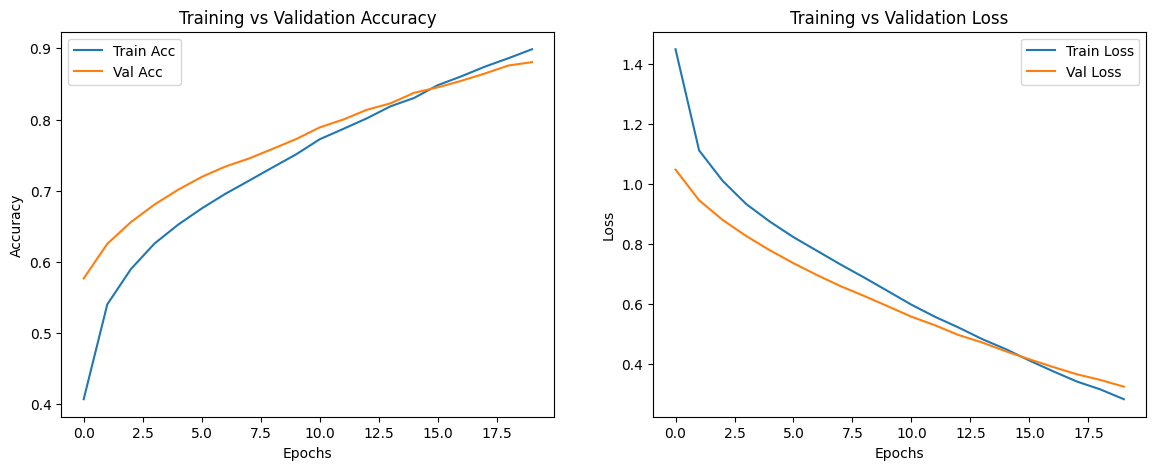

In [8]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1200
           1       0.98      0.97      0.97      1200
           2       0.93      0.92      0.92      1200
           3       0.91      0.93      0.92      1200
           4       0.97      0.95      0.96      1200

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



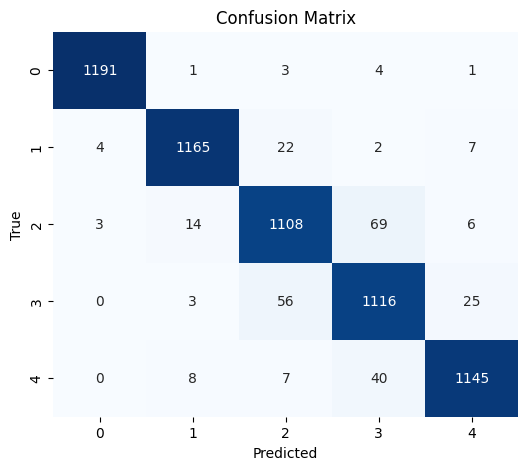

In [9]:
# Predictions
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.labels  

# Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
